In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV

from lightgbm import LGBMClassifier
import random
from scipy.stats import uniform, randint

from sklearn import metrics
import torch

import warnings
warnings.filterwarnings('ignore')


In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
df_train = pd.read_csv('./final_trainset.csv')
df_test = pd.read_csv('./final_testset.csv')

In [4]:
# split dataset
X = {}
y = {}

X['train'] = df_train.iloc[:, :-1]
y['train'] = df_train.benh21

X['test'] = df_test.iloc[:, :-1]
y['test'] = df_test.benh21

In [5]:
# parameter
p_folds = 20
p_iter = 1000
p_estimators = 300
p_learning_rate = 0.00001

# LGBM
params = {
    'num_leaves': randint(5, 50),
    'max_depth': randint(5, 10)
}

In [6]:
lgbm = LGBMClassifier(random_state=42, n_estimators=p_estimators, learning_rate=p_learning_rate)

In [7]:
folds = p_folds
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
model_lgbm = RandomizedSearchCV(lgbm, param_distributions=params, n_iter=p_iter, scoring='roc_auc', n_jobs=-1, cv=skf.split(X['train'], y['train']), verbose=-1, random_state=1001)
model_lgbm.fit(X['train'], y['train'])

[LightGBM] [Info] Number of positive: 2183, number of negative: 2183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 4366, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7dd49d1ebdf0>,
                   estimator=LGBMClassifier(learning_rate=1e-05,
                                            n_estimators=300, random_state=42),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7dd49b96db40>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7dd49b96d7e0>},
                   random_state=1001, scoring='roc_auc', verbose=-1)

In [8]:
print(model_lgbm.best_estimator_)
print(model_lgbm.best_params_)

LGBMClassifier(learning_rate=1e-05, max_depth=9, n_estimators=300,
               num_leaves=49, random_state=42)
{'max_depth': 9, 'num_leaves': 49}


In [9]:
from joblib import dump, load
dump(model_lgbm.best_estimator_, 'LightGBM_model_state.joblib')

['LightGBM_model_state.joblib']

In [10]:
best_lgbm = LGBMClassifier(**model_lgbm.best_estimator_.get_params())
best_lgbm.fit(X['train'], y['train'])
acc = best_lgbm.score(X['test'], y['test'])
print('Accuracy of LGBM : {}'.format(acc))

[LightGBM] [Info] Number of positive: 2183, number of negative: 2183
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 4366, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy of LGBM : 0.6619718309859155


In [11]:
lgbm_pred_test = model_lgbm.predict(X['test'])
lgbm_proba_test = model_lgbm.predict_proba(X['test'])[:,1]

Scoring Metrics for RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7dd49d1ebdf0>,
                   estimator=LGBMClassifier(learning_rate=1e-05,
                                            n_estimators=300, random_state=42),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7dd49b96db40>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7dd49b96d7e0>},
                   random_state=1001, scoring='roc_auc', verbose=-1) (Validation):
Balanced Accuracy Score = 0.60599
Accuracy Score = 0.66197
Precision Score = 0.28133
Recall Score = 0.51643
F1 Score = 0.36424
ROC AUC Score = 0.60599
Confusion Matrix:
[[642 281]
 [103 110]]
Classification_report
              precision    recall  f1-score   support

           0       0.86      0.70      0.77       923
           1       0.28      0.52      

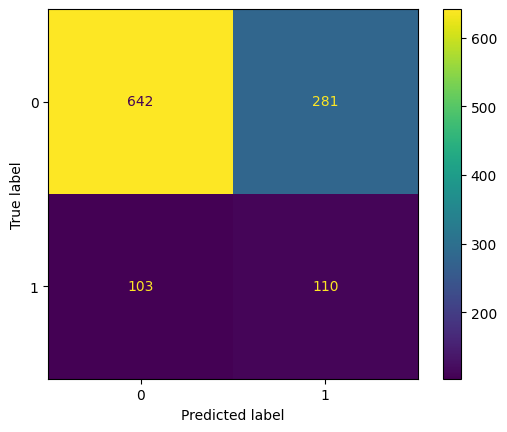

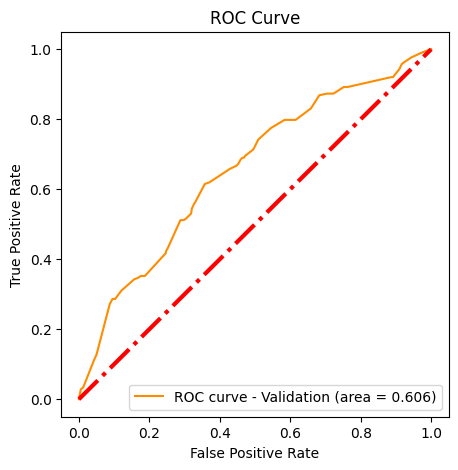

In [12]:
test_predict = pd.DataFrame(lgbm_pred_test)

print('Scoring Metrics for {} (Validation):'.format(model_lgbm))
print('Balanced Accuracy Score = {:.5f}'.format(metrics.balanced_accuracy_score(y['test'], test_predict)))
print('Accuracy Score = {:.5f}'.format(metrics.accuracy_score(y['test'], test_predict)))
print('Precision Score = {:.5f}'.format(metrics.precision_score(y['test'], test_predict)))
print('Recall Score = {:.5f}'.format(metrics.recall_score(y['test'], test_predict, labels=['0','1'])))
print('F1 Score = {:.5f}'.format(metrics.f1_score(y['test'], test_predict, labels=['0','1'])))
print('ROC AUC Score = {:.5f}'.format(metrics.roc_auc_score(y['test'], test_predict, labels=['0','1'])))

print('Confusion Matrix:')
print(metrics.confusion_matrix(y['test'], test_predict))

print("Classification_report")
print(metrics.classification_report(y['test'], test_predict, target_names=['0','1']))
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y['test'], test_predict)).plot()

# ROC Curve
fpr, tpr, _ = metrics.roc_curve(y['test'], lgbm_proba_test)

roc_auc = metrics.roc_auc_score(y['test'], test_predict, labels=['0','1'])

# Precision x Recall Curve
precision, recall, thresholds = metrics.precision_recall_curve(y['test'], lgbm_proba_test)

print('ROC Curve:')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve - Validation (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=3, linestyle='-.')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.show()